In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import plot_tree
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('datos_tarea25_clean.xlsx')
display(df.head())
print(f'\nLa frecuencia de cada clase es: \n{df.Color.value_counts()}')

,Unnamed: 0,Price,Levy,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Automatic gear box,Drive wheels,Left wheel,Color,Airbags,Turbo
0,0,39493,891,HYUNDAI,2016,Jeep,1,Diesel,2.0,160931,4,1,Front,1,1,4,0
1,1,1803,761,TOYOTA,2010,Hatchback,1,Hybrid,1.8,258909,4,1,Front,1,1,12,0
2,2,1098,394,TOYOTA,2014,Sedan,1,Hybrid,2.5,398069,4,1,Front,1,0,12,0
3,3,941,1053,MERCEDES-BENZ,2014,Sedan,1,Diesel,3.5,184467,6,1,Rear,1,1,12,0
4,4,1019,1055,LEXUS,2013,Jeep,1,Hybrid,3.5,138038,6,1,Front,1,1,12,0



La frecuencia de cada clase es: 
Color
0    2327
1    2013
Name: count, dtype: int64


In [3]:
numericas = df.select_dtypes(include = ['int', 'int32', 'int64', 'float', 'float32', 'float64']).columns.tolist()
categoricas = [col for col in df.columns.tolist() if col not in numericas]

columns_to_encode = ['Manufacturer', 'Category', 'Fuel type', 'Drive wheels']
df = pd.get_dummies(df, columns = columns_to_encode, drop_first = True)

variables = df.columns.tolist()
objetivo = ['Color']
predictoras = [col for col in variables if col not in objetivo]

X = df[predictoras]
y = df[objetivo]

In [4]:
arbol1 = DecisionTreeClassifier(min_samples_split = 200, criterion = 'entropy', max_depth = 25, random_state = 123)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}')
print(f'\nLa frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}')
arbol1.fit(X_train, y_train)
y_train_pred = arbol1.predict(X_train)
y_test_pred = arbol1.predict(X_test)
print()
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print(f'Diferencia de precisión entre train y test: {accuracy_score(y_train,y_train_pred)-accuracy_score(y_test,y_test_pred)}')
print()

accuracy_arbol_base = accuracy_score(y_test, y_test_pred)
print(f'Precisión del mejor modelo de árbol por GridSearchCV: {accuracy_arbol_base}')

La frecuencia de cada clase en train es: 
Color
0        0.542915
1        0.457085
Name: proportion, dtype: float64

La frecuencia de cada clase en test es: 
Color
0        0.509217
1        0.490783
Name: proportion, dtype: float64

Se tiene un accuracy para train de: 0.7128456221198156
Se tiene un accuracy para test de: 0.6774193548387096
Diferencia de precisión entre train y test: 0.03542626728110598

Precisión del mejor modelo de árbol por GridSearchCV: 0.6774193548387096


In [5]:
## tuneo y evaluación predictiva del modelo para variable dependiente categórica.

params = {
    'max_depth': [5, 10, 15, 20, 25, 30, 40, 50],
    'min_samples_split': [10, 15, 30, 50, 100, 200, 300],
    'criterion': ["gini", "entropy"]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Validación cruzada.
grid_search = GridSearchCV(estimator=arbol1, param_grid=params, cv=4, scoring = scoring_metrics, refit = 'accuracy')
grid_search.fit(X_train, y_train)

# Obtener resultados del grid search
results = pd.DataFrame(grid_search.cv_results_)
best_model = grid_search.best_estimator_
print('Parámetros del mejor modelo de árbol por GridSearchCV:')
print(best_model)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
accuracy_arbol_gscv = accuracy_score(y_test, y_test_pred)
print(f'Precisión del mejor modelo de árbol por GridSearchCV: {accuracy_arbol_gscv}')
# Mostrar resultados
# print("Resultados de Grid Search:")
# display(results[['params', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 'mean_test_f1_macro']])

Parámetros del mejor modelo de árbol por GridSearchCV:
DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10,
                       random_state=123)
Precisión del mejor modelo de árbol por GridSearchCV: 0.7523041474654378


In [6]:
# Accuracy:
grid_search = GridSearchCV(estimator=arbol1, param_grid=params, cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("El mejor modelo para 'Accuracy' es:")
print(grid_search.best_estimator_)
print()

# Precision:
grid_search = GridSearchCV(estimator=arbol1, param_grid=params, cv=4, scoring = scoring_metrics, refit='precision_macro')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("El mejor modelo para 'Precision' es:")
print(grid_search.best_estimator_)
print()

# Recall:
grid_search = GridSearchCV(estimator=arbol1, param_grid=params, cv=4, scoring = scoring_metrics, refit='recall_macro')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("El mejor modelo para 'Recall' es:")
print(grid_search.best_estimator_)
print()

# F1:
grid_search = GridSearchCV(estimator=arbol1, param_grid=params, cv=4, scoring = scoring_metrics, refit='f1_macro')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("El mejor modelo para 'F1' es:")
print(grid_search.best_estimator_)

El mejor modelo para 'Accuracy' es:
DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10,
                       random_state=123)

El mejor modelo para 'Precision' es:
DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10,
                       random_state=123)

El mejor modelo para 'Recall' es:
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10,
                       random_state=123)

El mejor modelo para 'F1' es:
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10,
                       random_state=123)


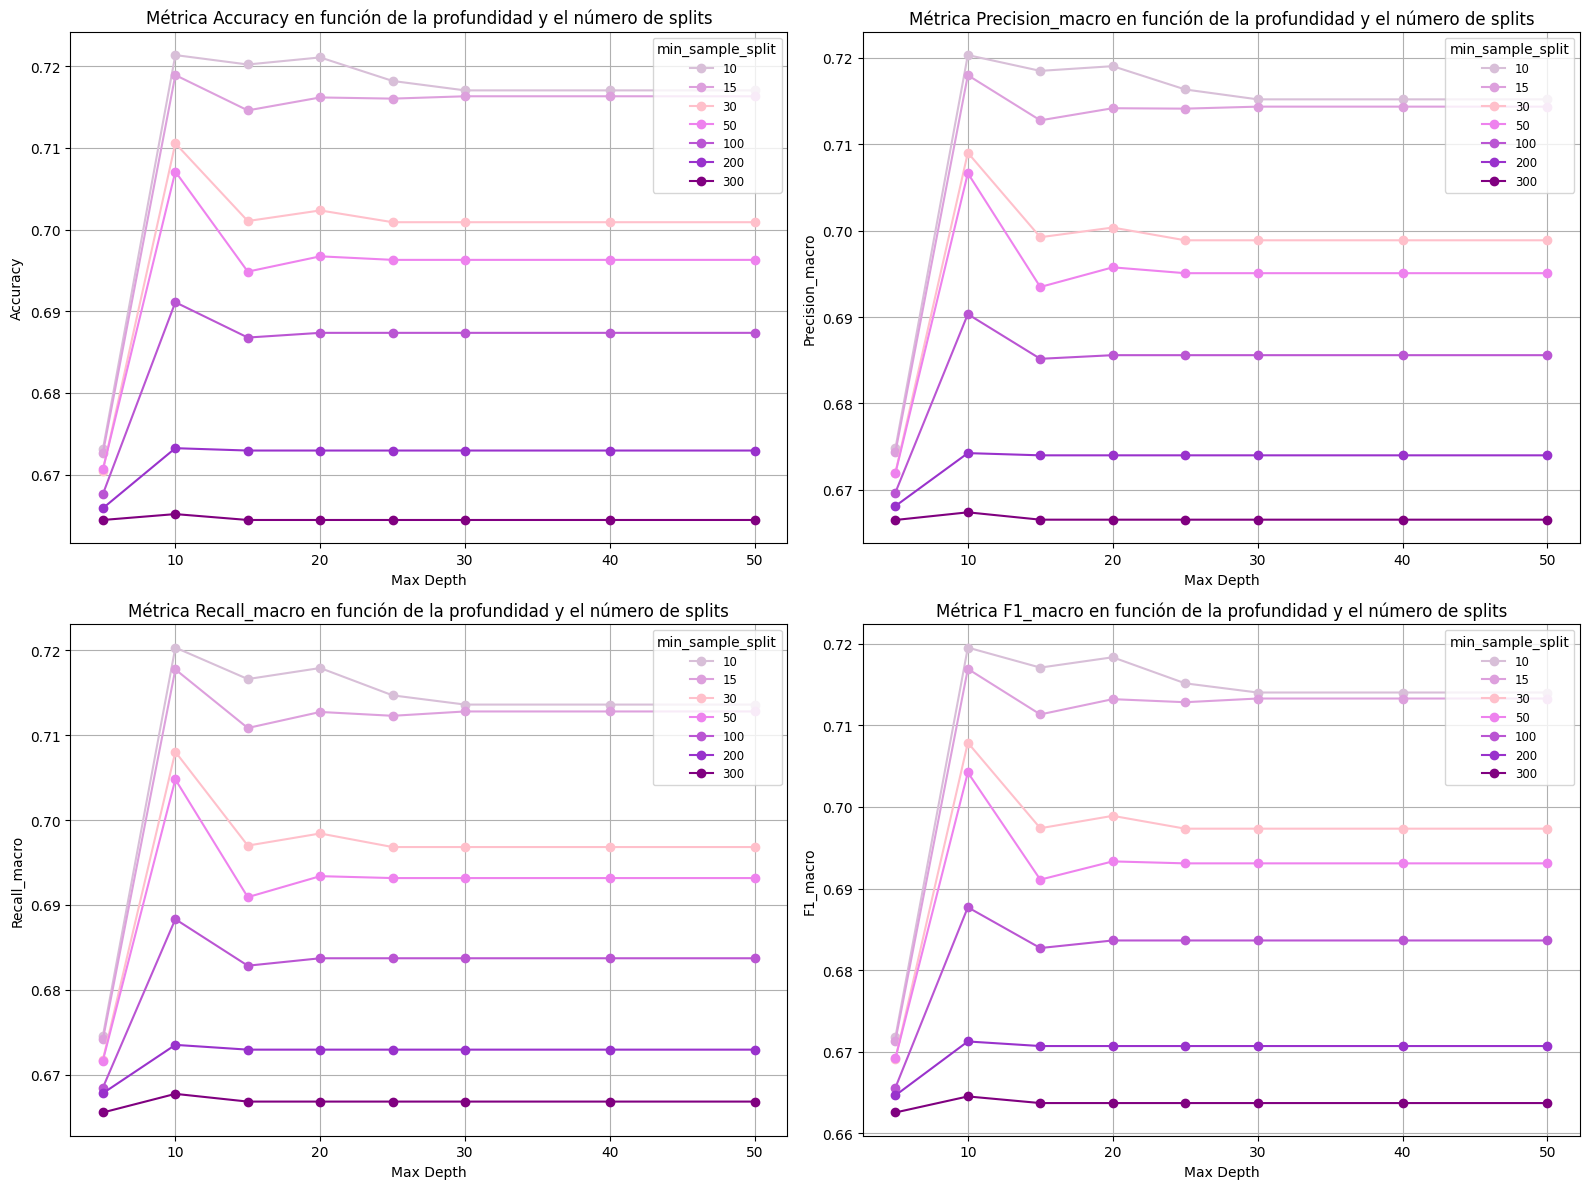

In [7]:
grid_search = GridSearchCV(estimator=arbol1, param_grid=params, cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search.fit(X_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

fig, axes = plt.subplots(2, 2, figsize = (16, 12))
axes = axes.flatten()
palette = ['thistle', 'plum', 'pink', 'violet', 'mediumorchid', 'darkorchid', 'purple']

for i, metric in enumerate(scoring_metrics):
    ax = axes[i]
    mean_col = f'mean_test_{metric}'
    std_col = f'std_test_{metric}'

    grouped = results.groupby(['param_max_depth', 'param_min_samples_split'])[[mean_col, std_col]].mean().reset_index()

    min_split_vals = sorted(grouped['param_min_samples_split'].unique())

    for j, val in enumerate(min_split_vals):
        subset = grouped[grouped['param_min_samples_split'] == val]
        x = subset['param_max_depth']
        y = subset[mean_col]        
        
        ax.plot(x, y, marker = 'o', label = f'{val}', color = palette[j])

    ax.set_title(f'Métrica {metric.capitalize()} en función de la profundidad y el número de splits')
    ax.set_xlabel('Max Depth')
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)
    ax.legend(title ='min_sample_split', loc = 'upper right', fontsize = 'small')
plt.tight_layout()
plt.show()

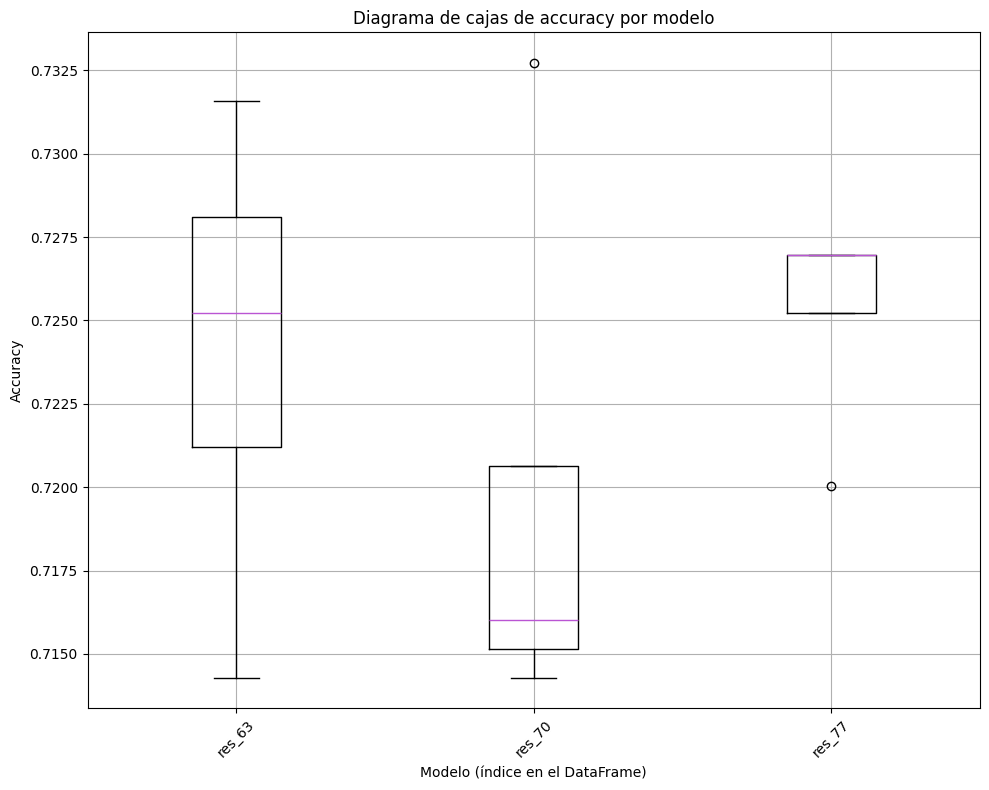

In [8]:
filtro = (
    (results['param_max_depth'] >= 10) &
    (results['param_max_depth'] <= 20) &
    (results['param_min_samples_split'] == 10) &
    (results['param_criterion'] == 'entropy')
)
subset = results[filtro]

split_cols = ['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy']

data = [row[split_cols].values for _, row in subset.iterrows()]
labels = [f'res_{i}' for i in subset.index]

plt.figure(figsize = (10, 8))
plt.boxplot(data, labels = labels, medianprops = {'color': 'mediumorchid'})
plt.title('Diagrama de cajas de accuracy por modelo')
plt.ylabel('Accuracy')
plt.xlabel('Modelo (índice en el DataFrame)')
plt.xticks(rotation = 45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Para seleccionar una parametrización específica y la mejor de acuerdo con el criterio
# de GridSearch, acceder a esta y conocer su combinación.
print(results.iloc[63].params)
modelo_63 = grid_search.cv_results_['params'][63]
best_model = grid_search.estimator.set_params(**modelo_63)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
accuracy_arbol_bmanual = accuracy_score(y_test, y_test_pred)
print(f'Precisión del mejor modelo de árbol por búsqueda manual: {accuracy_arbol_bmanual}')

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Precisión del mejor modelo de árbol por búsqueda manual: 0.6774193548387096


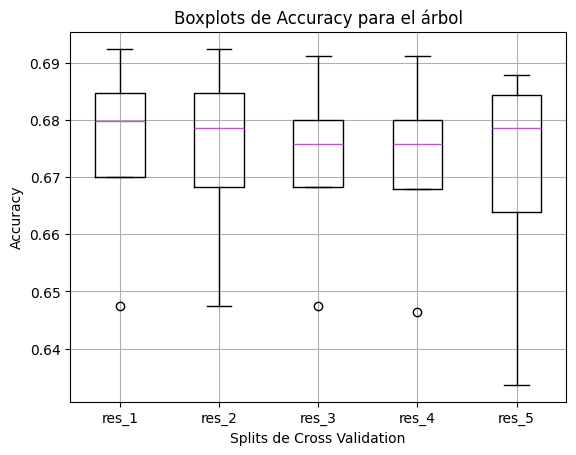

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}

In [10]:
sorted_results = results.sort_values(by='rank_test_accuracy', ascending=True).head(5)
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]


# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot(
    [res_1.values, res_2.values, res_3.values, res_4.values, res_5.values],
    labels = ['res_1','res_2','res_3','res_4','res_5'],
    medianprops = {'color': 'mediumorchid'}
)
plt.title('Boxplots de Accuracy para el árbol')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

sorted_results['params'].iloc[1]

In [11]:
# Obtener el índice original de res_2 desde sorted_results
res_2_index = sorted_results.index[1]  # La segunda mejor fila según la métrica

# Verificar la fila correspondiente en results
fila_res_2 = results.loc[res_2_index]

# Imprimir el índice y la fila por si quieres validar
print(f'Índice de res_2 en results: {res_2_index}')
print(fila_res_2[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']])


Índice de res_2 en results: 63
split0_test_accuracy    0.714286
split1_test_accuracy    0.731567
split2_test_accuracy    0.723502
split3_test_accuracy    0.726959
Name: 63, dtype: object


## Resultados - Árbol.

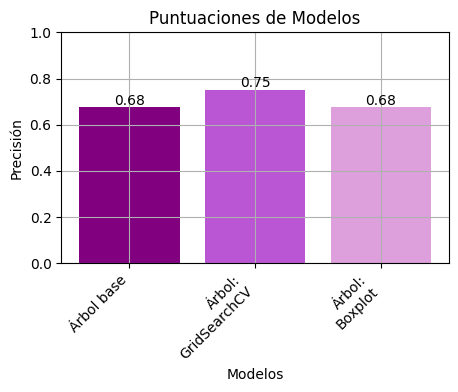

In [12]:
model_names = ['Árbol base', 'Árbol:\nGridSearchCV', 'Árbol:\nBoxplot']
scores = [accuracy_arbol_base, accuracy_arbol_gscv, accuracy_arbol_bmanual]
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(model_names)), scores, color=['purple', 'mediumorchid', 'plum'])
plt.xticks(np.arange(len(model_names)), model_names, rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.title('Puntuaciones de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.grid()
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', color='black')
plt.show()

In [13]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_train, y_train_pred)
print("Matriz de Confusión:")
print(conf_matrix)
print("\nMedidas de Desempeño:") 
print(classification_report(y_train, y_train_pred))
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusión:")
print(conf_matrix)
print("\nMedidas de Desempeño:")
print(classification_report(y_test, y_test_pred))

Matriz de Confusión:
[[1735  150]
 [ 127 1460]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1885
           1       0.91      0.92      0.91      1587

    accuracy                           0.92      3472
   macro avg       0.92      0.92      0.92      3472
weighted avg       0.92      0.92      0.92      3472

Matriz de Confusión:
[[346  96]
 [119 307]]

Medidas de Desempeño:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       442
           1       0.76      0.72      0.74       426

    accuracy                           0.75       868
   macro avg       0.75      0.75      0.75       868
weighted avg       0.75      0.75      0.75       868




Área bajo la curva ROC (AUC): 0.98


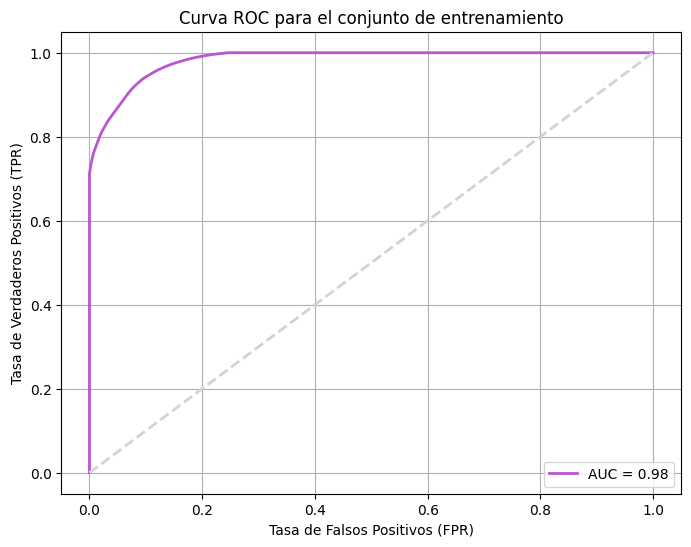

In [14]:
y_train_auc = pd.get_dummies(y_train,drop_first=True)
# Calcular el área bajo la curva ROC (AUC)
y_prob_train = best_model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train_auc, y_prob_train)
roc_auc = auc(fpr, tpr)
print(f"\nÁrea bajo la curva ROC (AUC): {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='mediumorchid', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el conjunto de entrenamiento')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Área bajo la curva ROC (AUC): 0.98


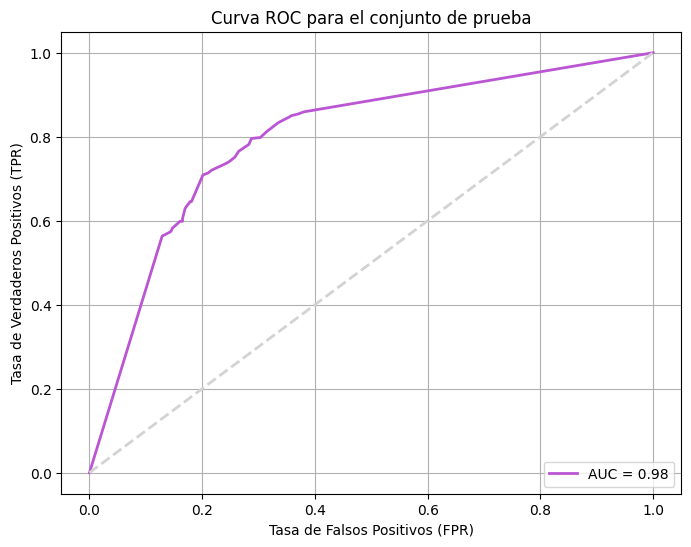

In [15]:
y_test_auc = pd.get_dummies(y_test,drop_first=True)
# Calcular el área bajo la curva ROC (AUC)
y_prob_test = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_auc, y_prob_test)
roc_auc_test = auc(fpr, tpr)
print(f"\nÁrea bajo la curva ROC (AUC): {roc_auc:.2f}")

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='mediumorchid', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para el conjunto de prueba')
plt.legend(loc="lower right")
plt.grid()
plt.show()

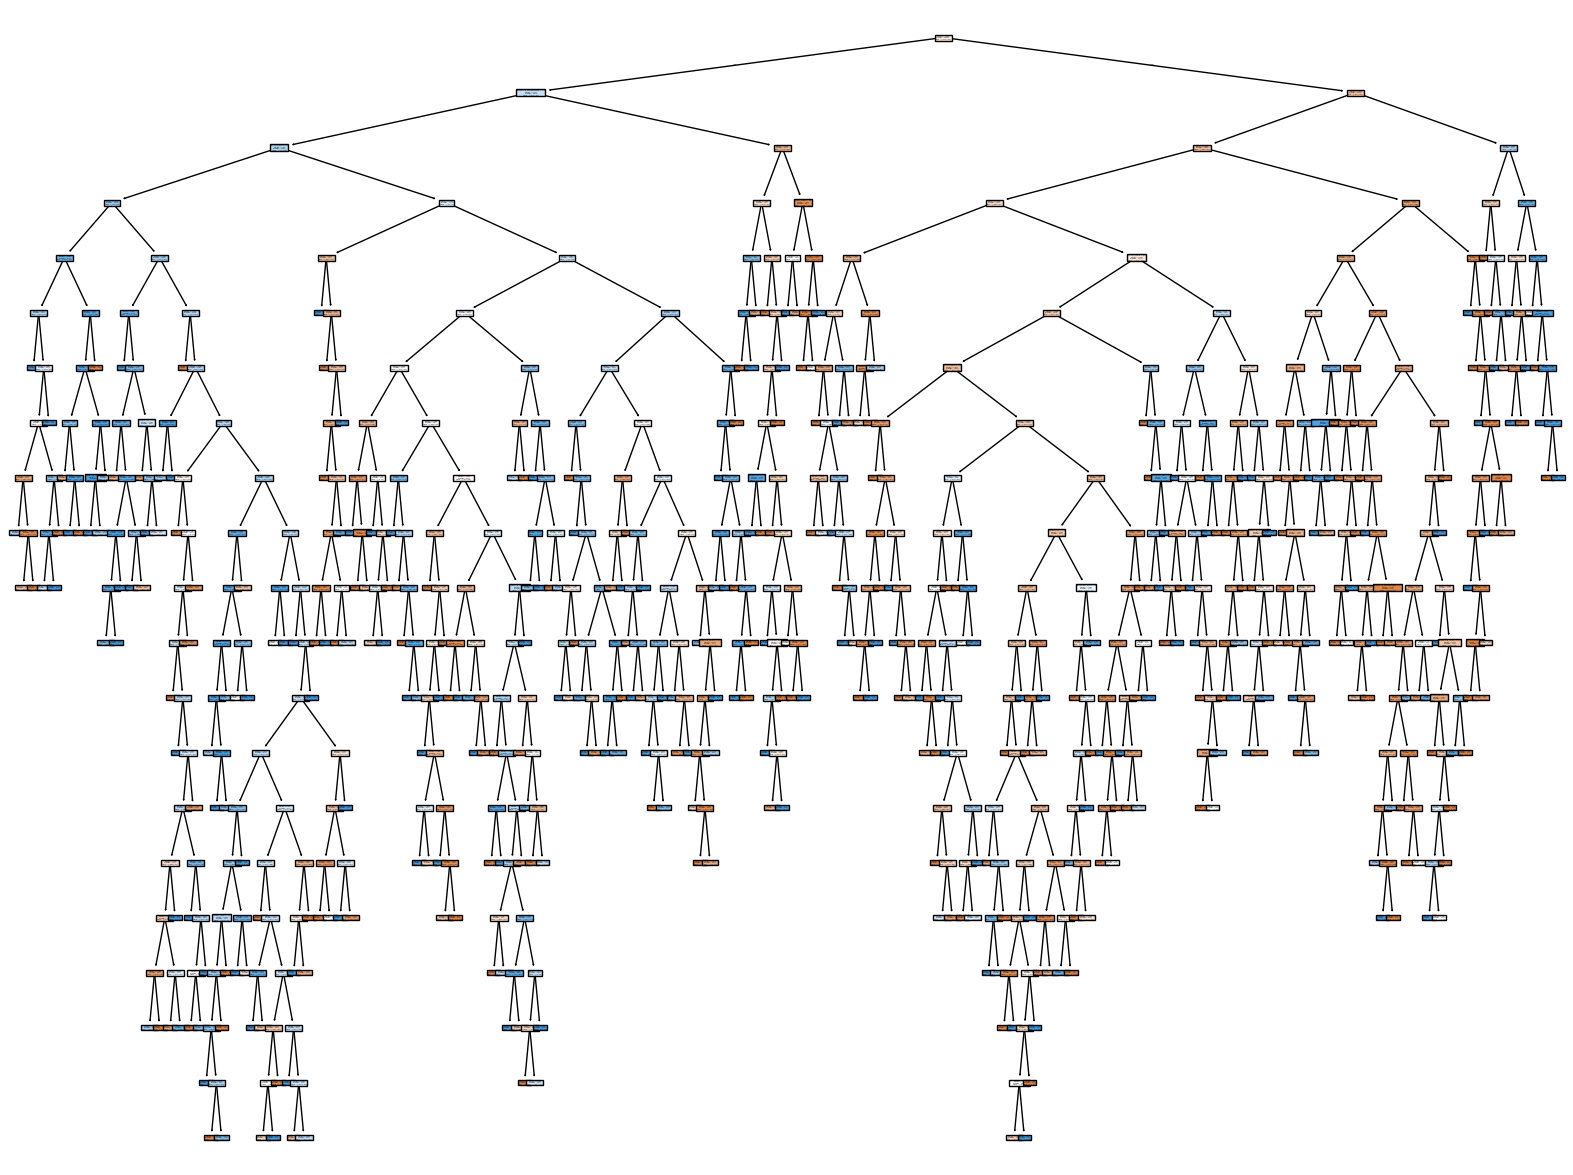

In [16]:
plt.figure(figsize=(20, 15))
plot_tree(best_model, feature_names=X.columns.tolist(), filled=True,
         proportion = True)
plt.show()

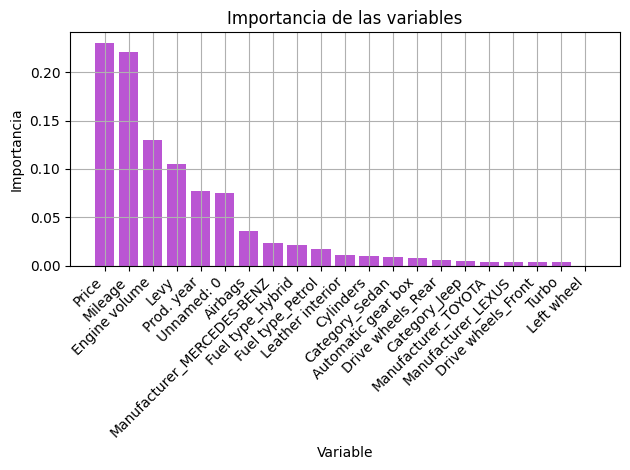

In [17]:
df_importancia = pd.DataFrame({'Variable': best_model.feature_names_in_, 'Importancia': best_model.feature_importances_}).sort_values(by='Importancia', ascending=False)
plt.bar(df_importancia['Variable'], df_importancia['Importancia'], color='mediumorchid')
plt.xlabel('Variable')
plt.ylabel('Importancia')
plt.title('Importancia de las variables')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

In [19]:
rules = export_text(best_model, feature_names = list(X.columns), show_weights = True)
with open('decision_tree_rules.txt', 'w', encoding='utf-8') as f:
    f.write(rules)
print(rules)

|--- Engine volume <= 2.30
|   |--- Manufacturer_MERCEDES-BENZ <= 0.50
|   |   |--- Fuel type_Petrol <= 0.50
|   |   |   |--- Price <= 2116.50
|   |   |   |   |--- Airbags <= 7.00
|   |   |   |   |   |--- Unnamed: 0 <= 650.00
|   |   |   |   |   |   |--- weights: [0.00, 9.00] class: 1
|   |   |   |   |   |--- Unnamed: 0 >  650.00
|   |   |   |   |   |   |--- Mileage <= 190438.50
|   |   |   |   |   |   |   |--- Prod. year <= 2011.50
|   |   |   |   |   |   |   |   |--- Mileage <= 51600.00
|   |   |   |   |   |   |   |   |   |--- weights: [1.00, 2.00] class: 1
|   |   |   |   |   |   |   |   |--- Mileage >  51600.00
|   |   |   |   |   |   |   |   |   |--- Unnamed: 0 <= 2336.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [2.00, 1.00] class: 0
|   |   |   |   |   |   |   |   |   |--- Unnamed: 0 >  2336.00
|   |   |   |   |   |   |   |   |   |   |--- weights: [8.00, 0.00] class: 0
|   |   |   |   |   |   |   |--- Prod. year >  2011.50
|   |   |   |   |   |   |   |   |--- Mileage

# Random Forest.

In [18]:
# n_estimators: Número de árboles en el bosque
# max_depth: Profundidad máxima de cada árbol
# min_samples_split: Número mínimo de muestras requeridas para dividir un nodo interno
# min_samples_leaf: Número mínimo de muestras requeridas para estar en un nodo hoja
# max_features: Número o proporción de características para ajustar cada árbol
# bootstrap: Si se deben realizar remuestreos con reemplazo (True) o sin reemplazo (False)
# n_jobs: Número de trabajadores para entrenar los árboles de forma paralela
# random_state: Semilla para reproducibilidad
RF_model = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_depth = 25, min_samples_split = 10, criterion = 'entropy', min_samples_leaf = 10, random_state=123)
RF_model.fit(X_train, y_train)
y_train_pred = RF_model.predict(X_train)
y_test_pred = RF_model.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print(f'Diferencia de precisión entre train y test: {accuracy_score(y_train,y_train_pred)-accuracy_score(y_test,y_test_pred)}')
print()

# Evaluar el rendimiento del modelo
accuracy_rf_base = accuracy_score(y_test, y_test_pred)
print(f'Precisión del modelo con RF estándar: {accuracy_rf_base}')

Se tiene un accuracy para train de: 0.8125
Se tiene un accuracy para test de: 0.7592165898617511
Diferencia de precisión entre train y test: 0.05328341013824889

Precisión del modelo con RF estándar: 0.7592165898617511


In [19]:
params = {
    'n_estimators' : [50, 100, 200],
    'max_depth': [10, 15, 20, 25],
    'bootstrap': [True, False],
    'min_samples_leaf' : [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100],
    'criterion': ["gini", "entropy"]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#recordar que arbol2 es el árbol cuyas VI son todas las variables.
# cv = crossvalidation
grid_search_RF = GridSearchCV(estimator=RF_model, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=25,
                                              min_samples_leaf=10,
                                              min_samples_split=10,
                                              random_state=123),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25],
                         'min_samples_leaf': [5, 10, 20, 30],
                         'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100],
                         'n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [20]:
# Obtener el mejor modelo
best_model_RF = grid_search_RF.best_estimator_
print(grid_search_RF.best_estimator_)
y_pred_rf = best_model_RF.predict(X_test)
accuracy_rf_gscv = accuracy_score(y_test, y_pred_rf)
# Evaluar el rendimiento del modelo
print(f'Precisión del modelo: {accuracy_rf_gscv}')

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=15,
                       min_samples_leaf=5, n_estimators=50, random_state=123)
Precisión del modelo: 0.7845622119815668


In [21]:
# se procede a observar el posible sobreajuste comparando predicciones en train y test.
# predicciones significativamente mayores en train que en test puede indicar sobreajuste.
# Predicciones en conjunto de entrenamiento y prueba
y_train_pred = best_model_RF.predict(X_train)
y_test_pred = best_model_RF.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.9115783410138248
Se tiene un accuracy para test de: 0.7845622119815668


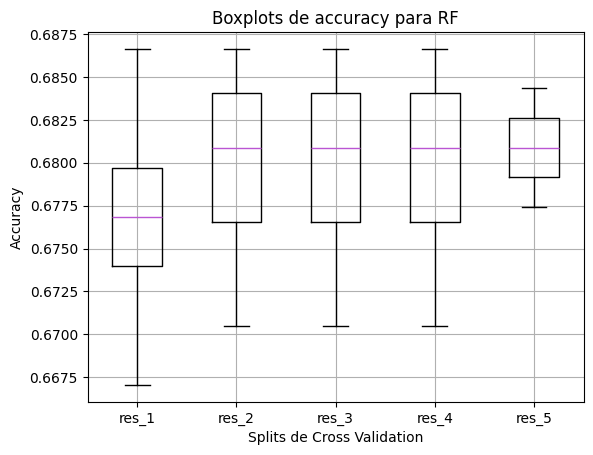

In [22]:
results = pd.DataFrame(grid_search_RF.cv_results_)
sorted_results = results.sort_values(by='mean_test_accuracy', ascending=True).head(5)

res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'], medianprops = {'color': 'mediumorchid'})
plt.title('Boxplots de accuracy para RF')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [23]:
# seleccionemos el segundo modelo dada su mayor robustez con respecto al propuesto por GridSearch
# nótese que "**" es para desempaquetar una lista de valores.
best_model_rf_boxplot = RandomForestClassifier(**sorted_results['params'].iloc[4],random_state=123)
best_model_rf_boxplot.fit(X_train, y_train)
print('Parámetros del mejor modelo de RF por boxplot:')
print(best_model_rf_boxplot.get_params)
print()
y_train_pred = best_model_rf_boxplot.predict(X_train)
y_test_pred = best_model_rf_boxplot.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print(f'Diferencia de precisión entre train y test: {accuracy_score(y_train,y_train_pred)-accuracy_score(y_test,y_test_pred)}')
print()


accuracy_rf_boxplot = accuracy_score(y_test, y_test_pred)
print(f'Precisión del modelo: {accuracy_rf_boxplot}')
print(f'Resultados para el modelo: {classification_report(y_test, y_test_pred)}')

Parámetros del mejor modelo de RF por boxplot:
<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=10, min_samples_leaf=30, min_samples_split=100,
                       n_estimators=50, random_state=123)>

Se tiene un accuracy para train de: 0.7183179723502304
Se tiene un accuracy para test de: 0.7039170506912442
Diferencia de precisión entre train y test: 0.01440092165898621

Precisión del modelo: 0.7039170506912442
Resultados para el modelo:               precision    recall  f1-score   support

           0       0.69      0.77      0.73       442
           1       0.73      0.63      0.68       426

    accuracy                           0.70       868
   macro avg       0.71      0.70      0.70       868
weighted avg       0.71      0.70      0.70       868



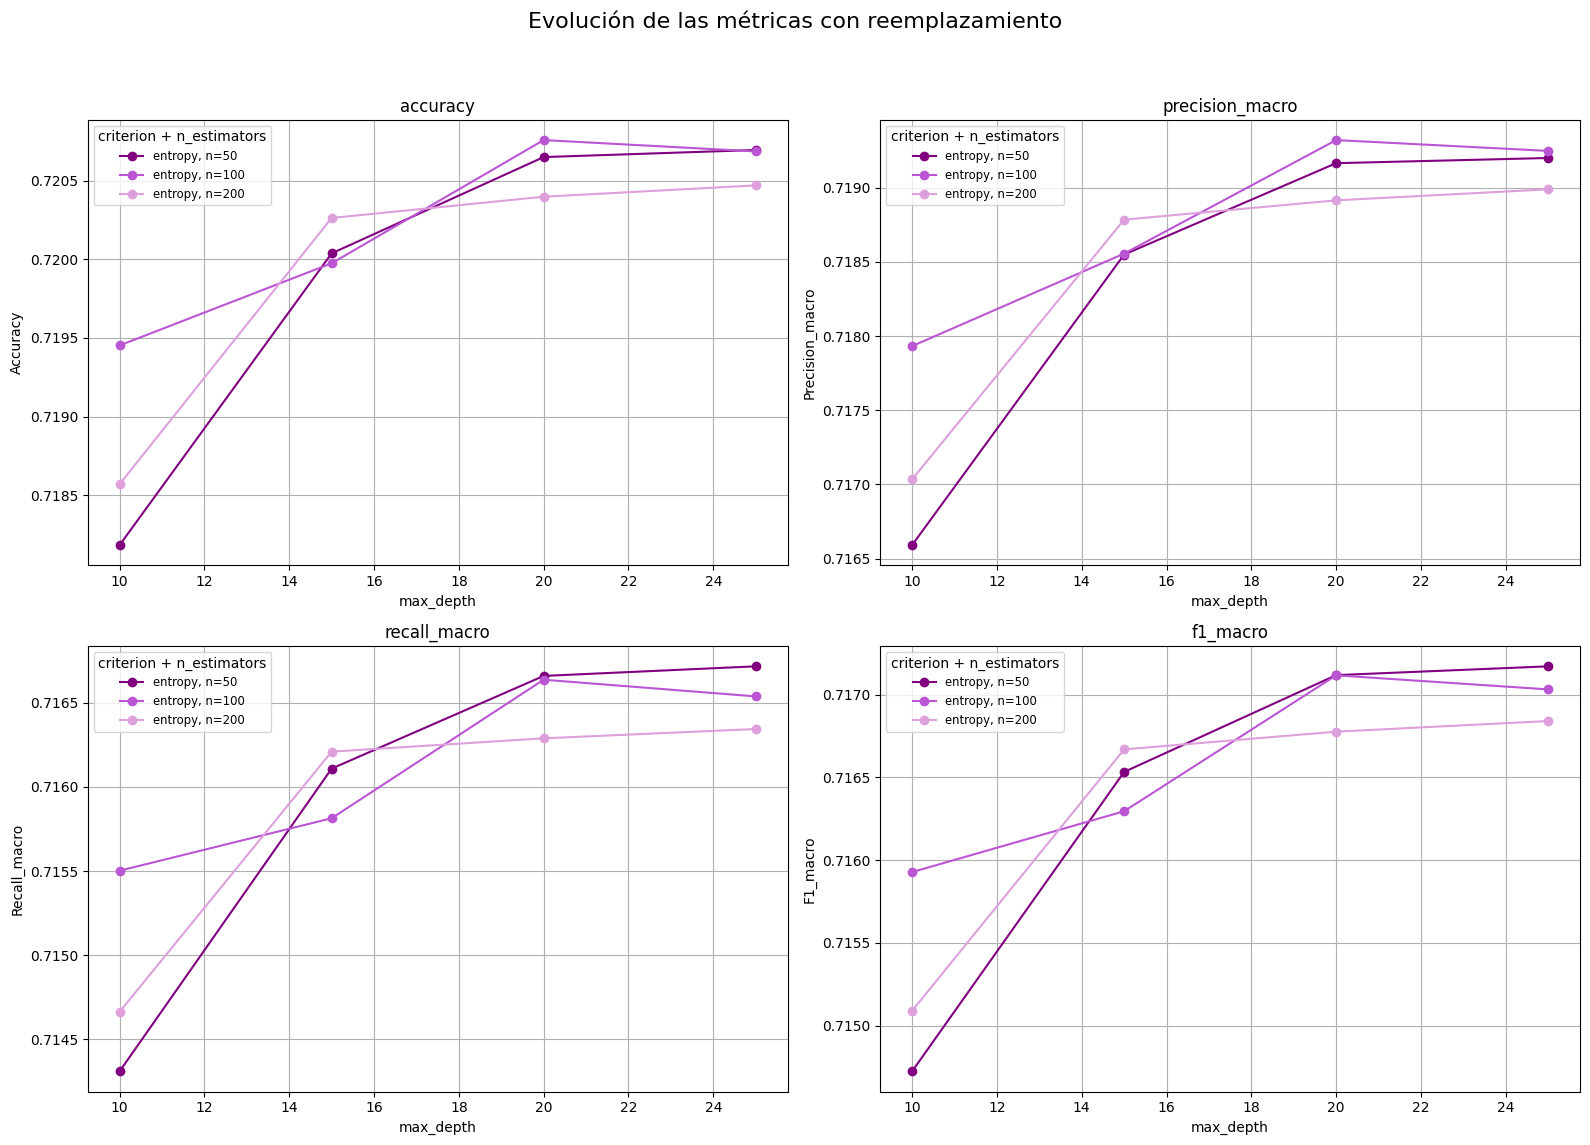

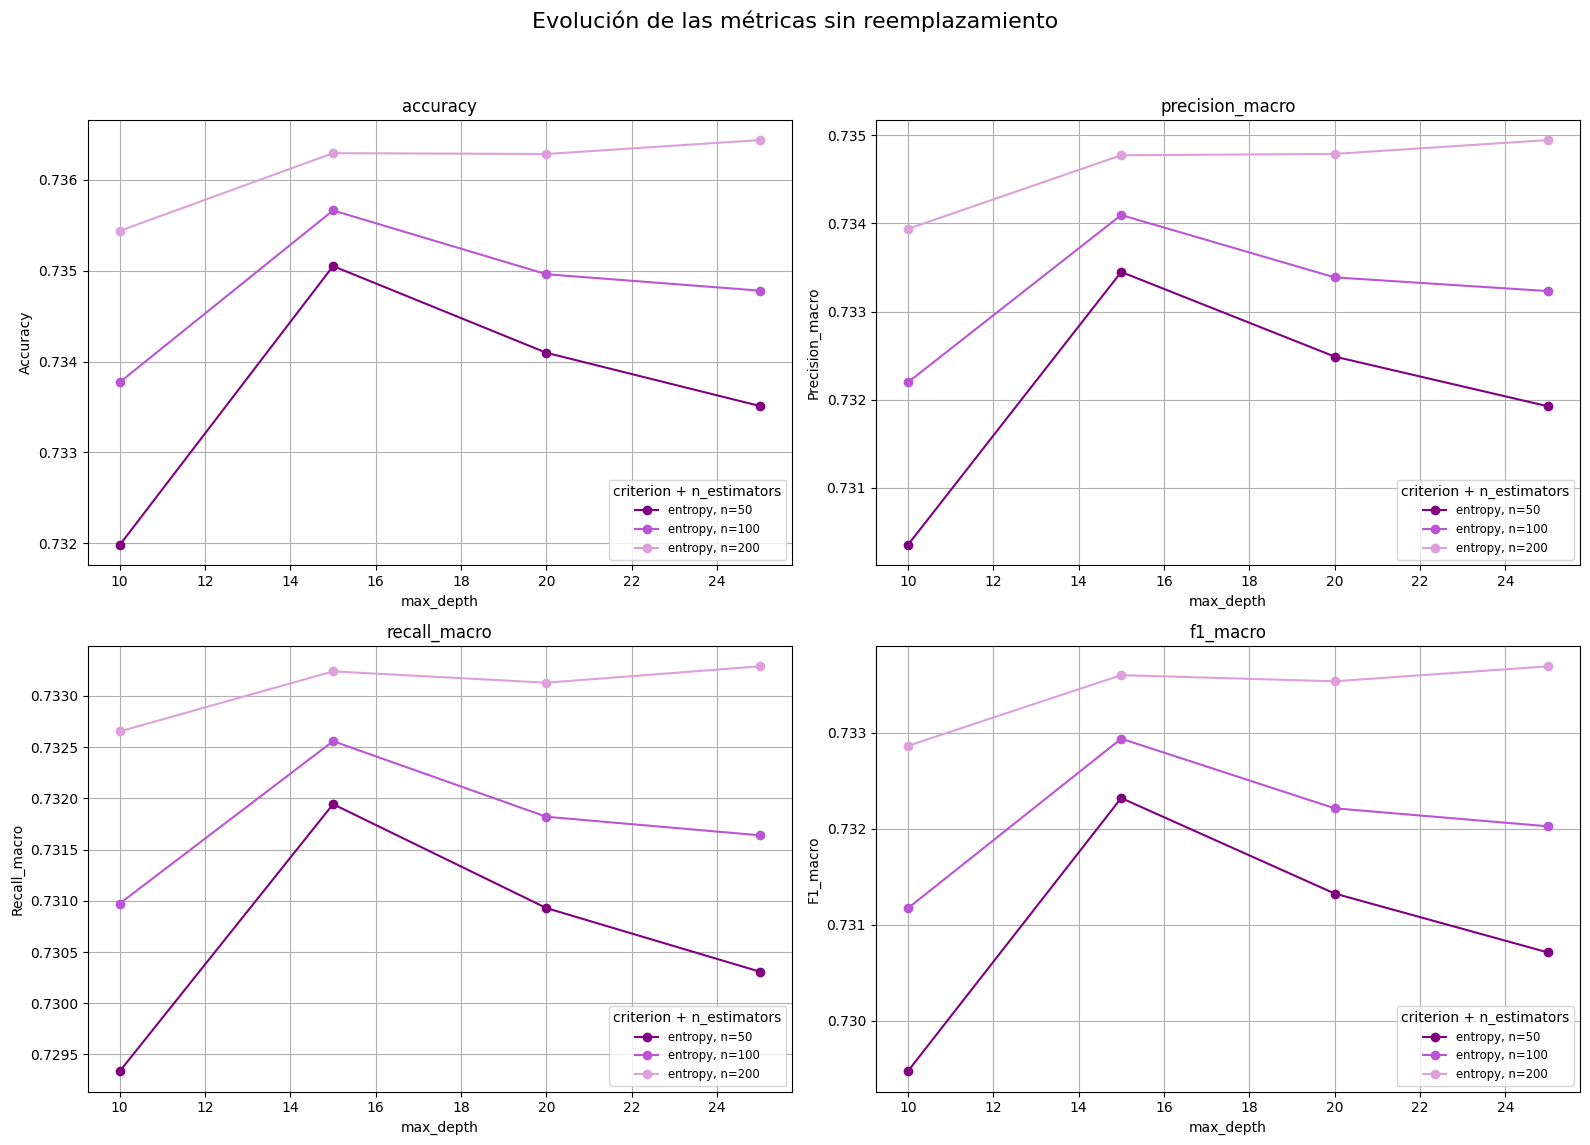

In [29]:
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
palette = ['purple', 'mediumorchid', 'plum', 'orchid', 'hotpink', 'violet', 'darkorchid']
titles = ['con reemplazamiento', 'sin reemplazamiento']

# Asegúrate de que 'results' esté definido como:
# results = pd.DataFrame(grid_search_RF.cv_results_)

# Convertir parámetros categóricos si hace falta (evita errores de agrupación)
results['param_bootstrap'] = results['param_bootstrap'].astype(bool)
results['param_criterion'] = results['param_criterion'].astype(str)

# Iterar por valor de bootstrap (una figura por valor)
index = 0
for boot in [True, False]:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Filtrar por bootstrap y por cada criterio
    for crit in ['entropy']:
        filtered = results[
            (results['param_bootstrap'] == boot) &
            (results['param_criterion'] == crit)
        ]

        for i, metric in enumerate(scoring_metrics):
            ax = axes[i]
            mean_col = f'mean_test_{metric}'

            grouped = filtered.groupby(
                ['param_max_depth', 'param_n_estimators']
            )[mean_col].mean().reset_index()

            for j, n_est in enumerate(sorted(grouped['param_n_estimators'].unique())):
                subset = grouped[grouped['param_n_estimators'] == n_est]
                ax.plot(subset['param_max_depth'], subset[mean_col],
                        marker='o', label=f'{crit}, n={n_est}',
                        color=palette[j % len(palette)])

            ax.set_title(f'{metric}')
            ax.set_xlabel('max_depth')
            ax.set_ylabel(metric.capitalize())
            ax.grid(True)
            ax.legend(title='criterion + n_estimators', fontsize='small')

    plt.suptitle(f'Evolución de las métricas {titles[index]}', fontsize=16)
    index += 1
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

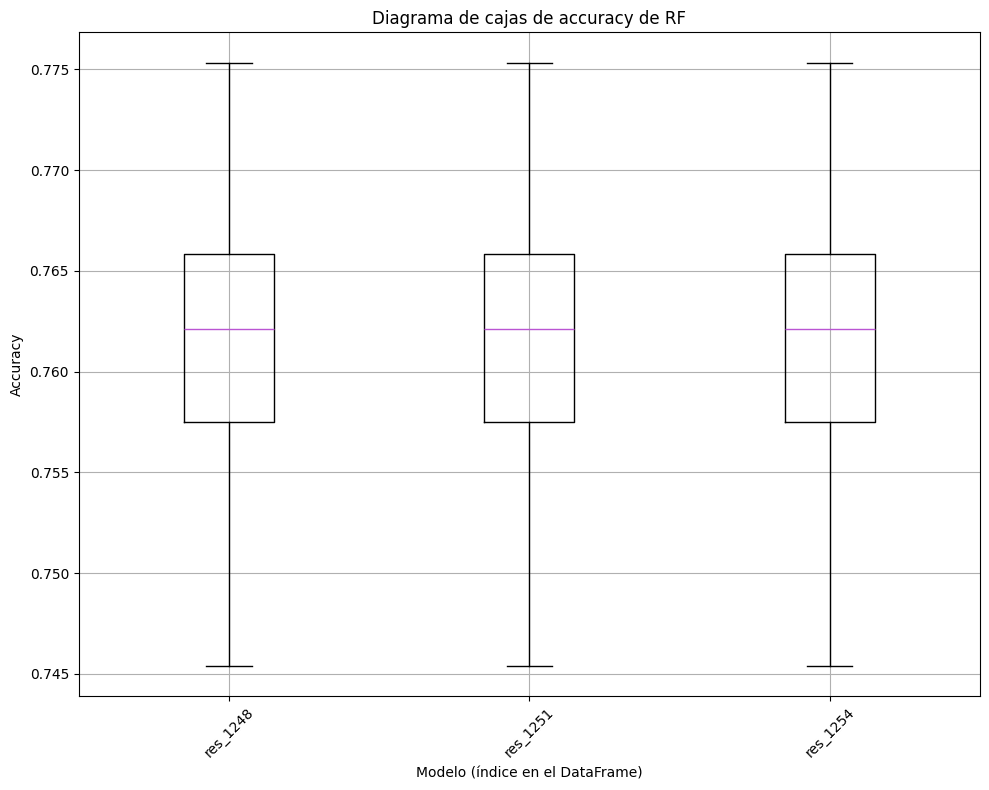

In [25]:
# Filtrar por condiciones del modelo
filtro = (
    (results['param_max_depth'] == 15) &
    (results['param_n_estimators'] == 50) &
    (results['param_criterion'] == 'entropy')
)

# Seleccionar subset
subset = results[filtro]

# Columnas de los splits
split_cols = ['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy']

# Calcular la media de accuracy en los splits
subset['mean_accuracy'] = subset[split_cols].mean(axis = 1)

# Filtrar por accuracy media > 0.7
subset = subset[subset['mean_accuracy'] > 0.76]

# Construir los datos para el boxplot
data = [row[split_cols].values for _, row in subset.iterrows()]
labels = [f'res_{i}' for i in subset.index]

# Dibujar el boxplot
plt.figure(figsize = (10, 8))
plt.boxplot(data, labels = labels, medianprops = {'color': 'mediumorchid'})
plt.title('Diagrama de cajas de accuracy de RF')
plt.ylabel('Accuracy')
plt.xlabel('Modelo (índice en el DataFrame)')
plt.xticks(rotation = 45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
print(results.iloc[1254].params)
modelo_1254 = grid_search_RF.cv_results_['params'][1254]
best_model = grid_search_RF.estimator.set_params(**modelo_1254)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
accuracy_modelo_1254 = accuracy_score(y_test, y_test_pred)
print(f'Precisión del modelo 1254 por búsqueda manual: {accuracy_modelo_1254}')

{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
Precisión del modelo 1254 por búsqueda manual: 0.7592165898617511


## Resultados RF.

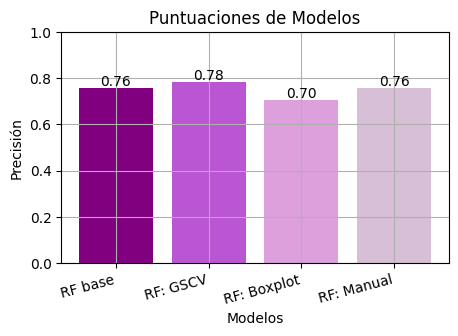

In [27]:
model_names = ['RF base', 'RF: GSCV', 'RF: Boxplot', 'RF: Manual']
scores = [accuracy_rf_base, accuracy_rf_gscv, accuracy_rf_boxplot, accuracy_modelo_1254]
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(model_names)), scores, color=['purple', 'mediumorchid', 'plum', 'thistle'])
plt.xticks(np.arange(len(model_names)), model_names, rotation=15, ha='right')
plt.ylim(0, 1.0)
plt.title('Puntuaciones de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.grid()
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', color='black')
plt.show()

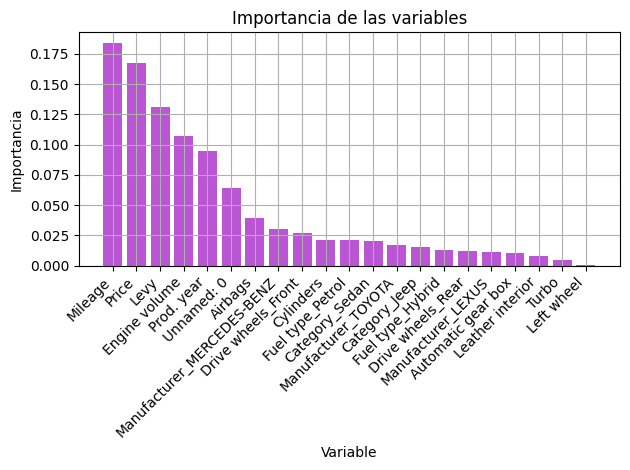

In [28]:
best_model = grid_search_RF.best_estimator_
df_importancia = pd.DataFrame({'Variable': best_model.feature_names_in_, 'Importancia': best_model.feature_importances_}).sort_values(by='Importancia', ascending=False)
plt.bar(df_importancia['Variable'], df_importancia['Importancia'], color='mediumorchid')
plt.xlabel('Variable')
plt.ylabel('Importancia')
plt.title('Importancia de las variables')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

# XG Boost.

In [30]:
xgb_classifier = XGBClassifier(booster = 'gbtree', n_estimators = 200, 
                               eta = 0.05, gamma = 3.5, random_state=123, max_depth = 25, tree_method = 'hist')
xgb_classifier.fit(X_train, y_train)
y_pred_base = xgb_classifier.predict(X_test)
# Evaluar el rendimiento del modelo
accuracy_xgb_base = accuracy_score(y_test, y_pred_base)

y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print()
print(f'Diferencia de precisión entre train y test: {accuracy_score(y_train,y_train_pred)-accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.8490783410138248
Se tiene un accuracy para test de: 0.7638248847926268

Diferencia de precisión entre train y test: 0.08525345622119807


In [31]:
params = {
    'n_estimators': [150, 200, 250],
    'eta' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma' : [0.5, 1, 1.5, 2],
    'max_depth': [3, 5, 10, 15]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

grid_search_XGB = GridSearchCV(estimator=xgb_classifier, 
                           param_grid=params, 
                           cv=4, scoring = scoring_metrics, refit='accuracy')
grid_search_XGB.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.05,
                                     eval_metric=None, feature_types=None,
                                     feature_weights=None, gamma=3.5,
                                     grow_policy=None, importance_type=None,
                                     interaction_con...
                                     max_delta_step=None, max_depth=25,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, ...),
             param_grid={'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'gamma': [0.5, 1, 1.5, 2], 'max_depth': [3, 5, 10, 15],
                         'n_estimators': [150, 200, 250]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

In [32]:
modelo_XGB = grid_search_XGB.best_estimator_

y_train_pred_xgb = modelo_XGB.predict(X_train)
y_test_pred_xgb = modelo_XGB.predict(X_test)
accuracy_xgb_gscv = accuracy_score(y_test,y_test_pred_xgb)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred_xgb)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred_xgb)}')
print()

print('Resultados para Modelo')
print(classification_report(y_test, y_test_pred_xgb))
print()

print('Parámetros del mejor estimador:')
params_interes = ['n_estimators', 'max_depth', 'eta', 'gamma']
for param in params_interes:
    valor = modelo_XGB.get_params()[param]
    print(f'- {param}: {valor}')

Se tiene un accuracy para train de: 0.9354838709677419
Se tiene un accuracy para test de: 0.7730414746543779

Resultados para Modelo
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       442
           1       0.78      0.75      0.76       426

    accuracy                           0.77       868
   macro avg       0.77      0.77      0.77       868
weighted avg       0.77      0.77      0.77       868


Parámetros del mejor estimador:
- n_estimators: 150
- max_depth: 10
- eta: 0.2
- gamma: 1


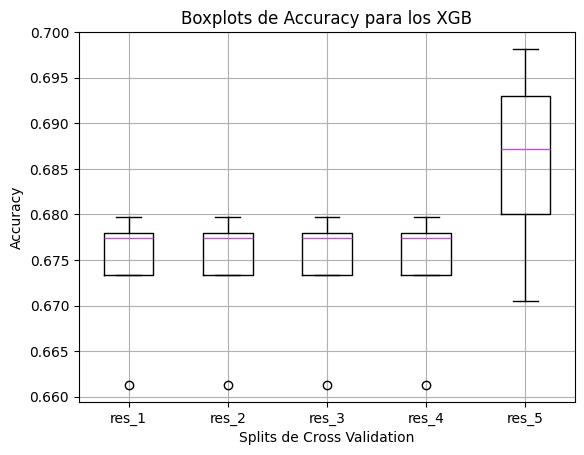

Parámetros del mejor estimador:
{'eta': 0.01, 'gamma': 1.5, 'max_depth': 3, 'n_estimators': 200}


In [33]:
results = pd.DataFrame(grid_search_XGB.cv_results_)

# Ordenar el DataFrame por la métrica de interés (por ejemplo, accuracy)
sorted_results = results.sort_values(by='mean_test_accuracy', ascending=True).head(5)
# se selecciona el modelo candidato, y se procede a analizar su robustez a lo largo de cross validation.
res_1 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[0]
res_2 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[1]
res_3 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[2]
res_4 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[3]
res_5 = sorted_results[['split0_test_accuracy', 'split1_test_accuracy','split2_test_accuracy', 'split3_test_accuracy']].iloc[4]

# Crear un boxplot para los cuatro valores de accuracy
plt.boxplot([res_1.values,res_2.values,res_3.values,res_4.values,res_5.values], labels = ['res_1','res_2','res_3','res_4','res_5'], medianprops = {'color': 'mediumorchid'})
plt.title('Boxplots de Accuracy para los XGB')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

print('Parámetros del mejor estimador:')
print(sorted_results['params'].iloc[4])

In [35]:
best_model_xgb_boxplot = XGBClassifier(**sorted_results['params'].iloc[4],random_state=123)
best_model_xgb_boxplot.fit(X_train, y_train)
print('Parámetros del mejor modelo de RF por boxplot:')
print(best_model_xgb_boxplot.get_params)
print()
y_train_pred = best_model_rf_boxplot.predict(X_train)
y_test_pred = best_model_rf_boxplot.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')
print(f'Diferencia de precisión entre train y test: {accuracy_score(y_train,y_train_pred)-accuracy_score(y_test,y_test_pred)}')
print()

accuracy_xgb_boxplot = accuracy_score(y_test, y_test_pred)
print(f'Precisión del modelo: {accuracy_rf_boxplot}')
print(f'Resultados para el modelo: {classification_report(y_test, y_test_pred)}')

Parámetros del mejor modelo de RF por boxplot:
<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=1.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, ...)>

Se tiene un accuracy para train de: 0.7183179723502304
Se tiene un accuracy para test de: 0.7039170506912442
Diferencia de precisión entre train y test: 0.01440092165898621

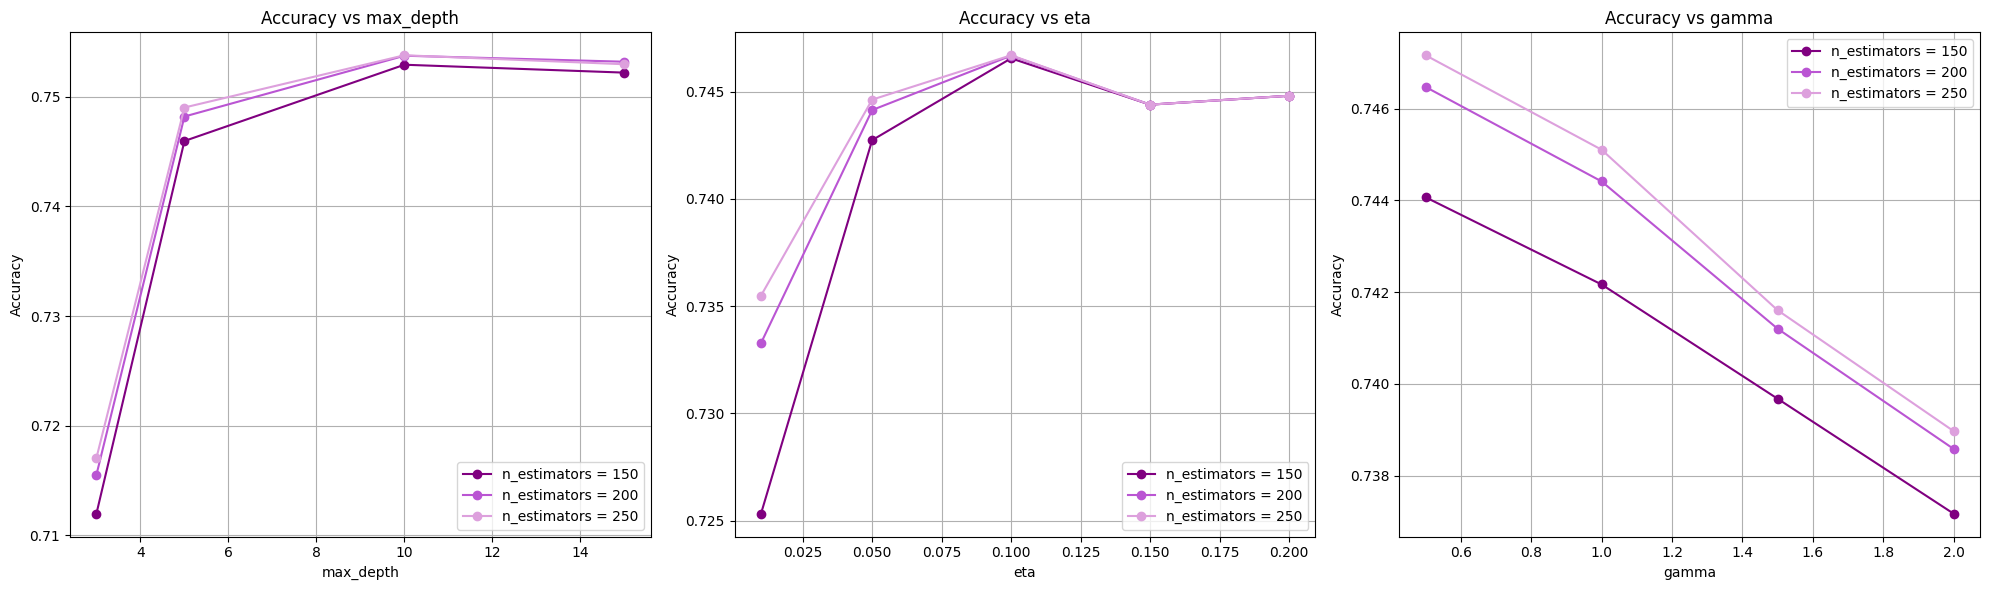

In [36]:
results = pd.DataFrame(grid_search_XGB.cv_results_)
fig, axes = plt.subplots(1, 3, figsize = (20, 6))
axes = axes.flatten()
palette = ['purple', 'mediumorchid', 'plum']

for i, n in enumerate(sorted(results['param_n_estimators'].unique())):
    subset = results[results['param_n_estimators'] == n]
    grouped = subset.groupby('param_max_depth')['mean_test_accuracy'].mean().reset_index()
    axes[0].plot(grouped['param_max_depth'], grouped['mean_test_accuracy'],
                 label = f'n_estimators = {n}', marker = 'o', color = palette[i])
axes[0].set_title('Accuracy vs max_depth')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)
for i, n in enumerate(sorted(results['param_n_estimators'].unique())):
    subset = results[results['param_n_estimators'] == n]
    grouped = subset.groupby('param_eta')['mean_test_accuracy'].mean().reset_index()
    axes[1].plot(grouped['param_eta'], grouped['mean_test_accuracy'],
                 label = f'n_estimators = {n}', marker = 'o', color = palette[i])
axes[1].set_title('Accuracy vs eta')
axes[1].set_xlabel('eta')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)
for i, n in enumerate(sorted(results['param_n_estimators'].unique())):
    subset = results[results['param_n_estimators'] == n]
    grouped = subset.groupby('param_gamma')['mean_test_accuracy'].mean().reset_index()
    axes[2].plot(grouped['param_gamma'], grouped['mean_test_accuracy'],
                 label = f'n_estimators = {n}', marker = 'o', color = palette[i])
axes[2].set_title('Accuracy vs gamma')
axes[2].set_xlabel('gamma')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()
plt.show()

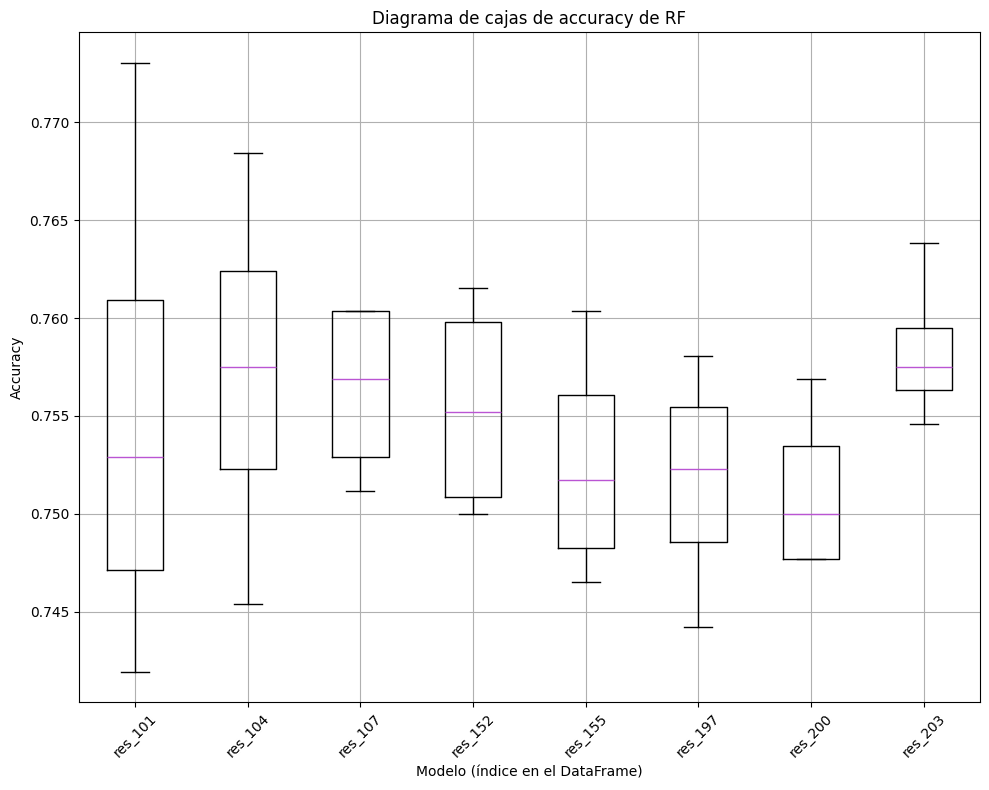

In [43]:
# Filtrar por condiciones del modelo
filtro = (
    (results['param_max_depth'] >= 5) &
    (results['param_max_depth'] <= 15) &
    (results['param_eta'] >= 0.1) &
    (results['param_gamma'] == 0.5) &
    (results['param_n_estimators'] == 250)
)

# Seleccionar subset
subset = results[filtro]

# Columnas de los splits
split_cols = ['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy']

# Calcular la media de accuracy en los splits
subset['mean_accuracy'] = subset[split_cols].mean(axis = 1)

# Filtrar por accuracy media > 0.7
subset = subset[subset['mean_accuracy'] > 0.75]

# Construir los datos para el boxplot
data = [row[split_cols].values for _, row in subset.iterrows()]
labels = [f'res_{i}' for i in subset.index]

# Dibujar el boxplot
plt.figure(figsize = (10, 8))
plt.boxplot(data, labels = labels, medianprops = {'color': 'mediumorchid'})
plt.title('Diagrama de cajas de accuracy de RF')
plt.ylabel('Accuracy')
plt.xlabel('Modelo (índice en el DataFrame)')
plt.xticks(rotation = 45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
print(results.iloc[203].params)
modelo_203 = grid_search_RF.cv_results_['params'][203]
best_model = grid_search_RF.estimator.set_params(**modelo_203)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
accuracy_modelo_203 = accuracy_score(y_test, y_test_pred)
print(f'Precisión del modelo 1254 por búsqueda manual: {accuracy_modelo_1254}')

{'eta': 0.2, 'gamma': 0.5, 'max_depth': 15, 'n_estimators': 250}
Precisión del modelo 1254 por búsqueda manual: 0.7592165898617511


## Resultados XGB.

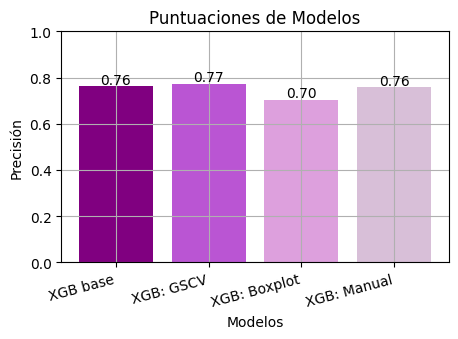

In [47]:
model_names = ['XGB base', 'XGB: GSCV', 'XGB: Boxplot', 'XGB: Manual']
scores = [accuracy_xgb_base, accuracy_xgb_gscv, accuracy_xgb_boxplot, accuracy_modelo_203]
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(model_names)), scores, color=['purple', 'mediumorchid', 'plum', 'thistle'])
plt.xticks(np.arange(len(model_names)), model_names, rotation=15, ha='right')
plt.ylim(0, 1.0)
plt.title('Puntuaciones de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.grid()
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', color='black')
plt.show()

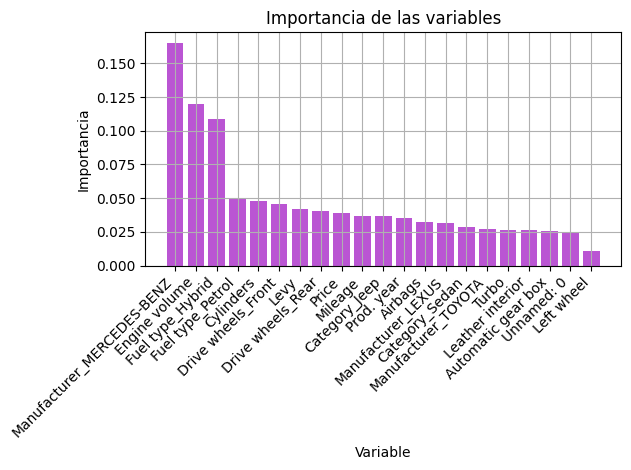

In [48]:
best_model = grid_search_XGB.best_estimator_
df_importancia = pd.DataFrame({'Variable': best_model.feature_names_in_, 'Importancia': best_model.feature_importances_}).sort_values(by='Importancia', ascending=False)
plt.bar(df_importancia['Variable'], df_importancia['Importancia'], color='mediumorchid')
plt.xlabel('Variable')
plt.ylabel('Importancia')
plt.title('Importancia de las variables')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

# Comparación de resultados.

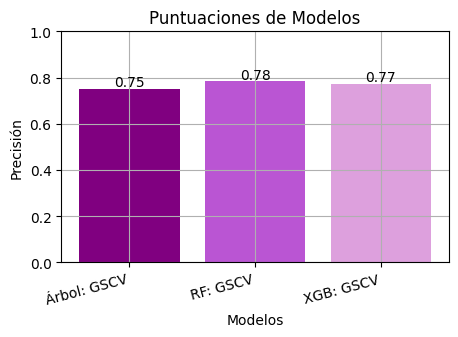

In [49]:
model_names = ['Árbol: GSCV', 'RF: GSCV', 'XGB: GSCV']
scores = [accuracy_arbol_gscv, accuracy_rf_gscv, accuracy_xgb_gscv]
plt.figure(figsize=(5, 3))
bars = plt.bar(np.arange(len(model_names)), scores, color=['purple', 'mediumorchid', 'plum', 'thistle'])
plt.xticks(np.arange(len(model_names)), model_names, rotation=15, ha='right')
plt.ylim(0, 1.0)
plt.title('Puntuaciones de Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.grid()
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', ha='center', color='black')

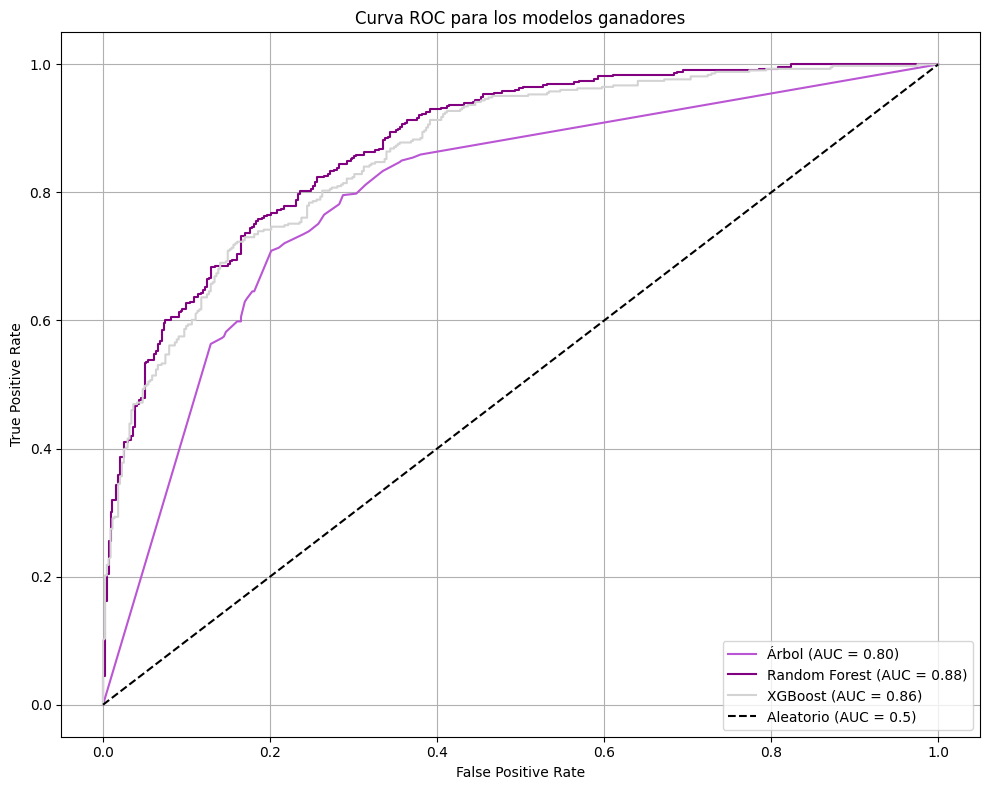

In [ ]:
# Modelo 1: árbol
modelo_1 = grid_search.best_estimator_
modelo_1.fit(X_train, y_train)
y_prob1 = modelo_1.predict_proba(X_test)[:, 1]
fpr1, tpr1, _ = roc_curve(y_test, y_prob1)
roc_auc1 = auc(fpr1, tpr1)

# Modelo 2: RF
modelo_2 = grid_search_RF.best_estimator_
modelo_2.fit(X_train, y_train)
y_prob2 = modelo_2.predict_proba(X_test)[:, 1]
fpr2, tpr2, _ = roc_curve(y_test, y_prob2)
roc_auc2 = auc(fpr2, tpr2)

# Modelo 3: XGB
modelo_3 = grid_search_XGB.best_estimator_
modelo_3.fit(X_train, y_train)
y_prob3 = modelo_3.predict_proba(X_test)[:, 1]
fpr3, tpr3, _ = roc_curve(y_test, y_prob3)
roc_auc3 = auc(fpr3, tpr3)

# Gráfica ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label = f'Árbol (AUC = {roc_auc1:.2f})', color='mediumorchid')
plt.plot(fpr2, tpr2, label = f'Random Forest (AUC = {roc_auc2:.2f})', color='purple')
plt.plot(fpr3, tpr3, label = f'XGBoost (AUC = {roc_auc3:.2f})', color='lightgrey')
plt.plot([0, 1], [0, 1], 'k--', label = 'Aleatorio (AUC = 0.5)')

plt.title('Curva ROC para los modelos ganadores')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid(True)
plt.tight_layout()
plt.show()